#### python kernel : 3.9.7

sudo apt-get install python3-pip

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from neuralprophet import NeuralProphet

#### 학습용 데이터 서버 업로드 (stfp를 이용)  
1.  (linux server) mkdir "폴더명"   
2.  (Window local) cmd 창 : 파일 디렉터리로 이동 -> sftp [ID]@[서버주소] -> pw 입력 -> 리눅스 서버 디렉터리 이동 -> put(window local 파일명) 

학습데이터 불러오기


In [20]:
#data 불러오기
data=pd.read_excel('/home/ykkim/Train_data/무림페이퍼_15분사용전력_210401-220630.xlsx')   #pip install openpyxl 

In [21]:
data=data.drop(['등록시각'],axis=1)

data['기준시각']=pd.to_datetime(data['기준시각'])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42766 entries, 0 to 42765
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   기준시각         42766 non-null  datetime64[ns]
 1   직전 15분 사용전력  42766 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 668.3 KB


In [23]:
data.tail(20).to_excel('/home/ykkim/Test_data/무림페이퍼_15분사용전력_Test.xlsx',index=False)

module 불러오기 (git 연동 & clone 후 )


('/home/ykkim/Baseline_Analysis/4. Supervised_model/neural_prophet_module.py')

In [4]:
import sys
sys.path.append('/home/ykkim/Baseline_Analysis/4. Supervised_model/' )  #모듈 저장 위치 지정 
print(sys.path)

['/home/ykkim/.jupyter', '/home/ykkim/anaconda3/envs/NeuralProphet/lib/python39.zip', '/home/ykkim/anaconda3/envs/NeuralProphet/lib/python3.9', '/home/ykkim/anaconda3/envs/NeuralProphet/lib/python3.9/lib-dynload', '', '/home/ykkim/anaconda3/envs/NeuralProphet/lib/python3.9/site-packages', '/home/ykkim/Baseline_Analysis/4. Supervised_model/']


In [5]:
import neural_prophet_module as NP

In [6]:
#lag, diff feature 생성
NP.gen_feature_lag(data,'직전 15분 사용전력','l_1',1)
NP.gen_feature_lag(data,'직전 15분 사용전력','l_2',2)
NP.gen_feature_lag(data,'직전 15분 사용전력','l_3',3)
NP.gen_feature_lag(data,'직전 15분 사용전력','l_4',4)
NP.gen_feature_lag(data,'직전 15분 사용전력','l_5',5)


NP.gen_feature_diff(data,'직전 15분 사용전력','d_1',1)
NP.gen_feature_diff(data,'직전 15분 사용전력','d_2',2)
NP.gen_feature_diff(data,'직전 15분 사용전력','d_3',3)
NP.gen_feature_diff(data,'직전 15분 사용전력','d_4',4)
NP.gen_feature_diff(data,'직전 15분 사용전력','d_5',5)

,기준시각,직전 15분 사용전력,l_1,l_2,l_3,l_4,l_5,d_1,d_2,d_3,d_4,d_5
0,2021-04-01 00:00:00,7224.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-04-01 00:15:00,7274.4,7224.0,NaN,NaN,NaN,NaN,50.4,NaN,NaN,NaN,NaN
2,2021-04-01 00:30:00,7442.4,7274.4,7224.0,NaN,NaN,NaN,168.0,218.4,NaN,NaN,NaN
3,2021-04-01 00:45:00,7392.0,7442.4,7274.4,7224.0,NaN,NaN,-50.4,117.6,168.0,NaN,NaN
4,2021-04-01 01:00:00,7576.8,7392.0,7442.4,7274.4,7224.0,NaN,184.8,134.4,302.4,352.8,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
42761,2022-06-30 22:45:00,5628.0,5644.8,5594.4,5644.8,5678.4,5644.8,-16.8,33.6,-16.8,-50.4,-16.8
42762,2022-06-30 23:00:00,5560.8,5628.0,5644.8,5594.4,5644.8,5678.4,-67.2,-84.0,-33.6,-84.0,-117.6
42763,2022-06-30 23:15:00,5493.6,5560.8,5628.0,5644.8,5594.4,5644.8,-67.2,-134.4,-151.2,-100.8,-151.2
42764,2022-06-30 23:30:00,5527.2,5493.6,5560.8,5628.0,5644.8,5594.4,33.6,-33.6,-100.8,-117.6,-67.2


In [7]:
# train_test split
df_train,df_test=NP.train_test_split(data,Time_name='기준시각',train_cut_date='2022-06-30',val_cut_date='2022-06-30',end_time='2022-06-30 23:45:00',want_val='N')  #validation set은 추후에 분리

train_df= 2021-04-01 00:00:00 ~ 2022-06-29 23:45:00 , 42670
test_df= 2022-06-30 00:00:00 ~ 2022-06-30 23:45:00 , 96


In [8]:
#모델 학습
model, metrics= NP.NP_model(df_train,df_test,Time_name='기준시각',Y_name='직전 15분 사용전력',num_futureregressor=10,val_p=0.1)   # pip install livelossplot

WARNING - (py.warnings._showwarnmsg) - /home/ykkim/Baseline_Analysis/4. Supervised_model/neural_prophet_module.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train.rename(columns={Time_name: "ds", Y_name: "y"}, inplace=True)

WARNING - (py.warnings._showwarnmsg) - /home/ykkim/Baseline_Analysis/4. Supervised_model/neural_prophet_module.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.rename(columns={Time_name: "ds", Y_name: "y"}, inplace=True)

INFO - (NP.df_utils._infer_frequency) - Major frequency 15T corresponds to 99.984% of the data.
INFO - (NP.df_utils._infer_frequency) - Dataframe freq automa

SmoothL1Loss:  1.5161012170473278e-08
MAE(Train):  0.33104352720348185
MAE(val):  0.2776077158185115


INFO - (NP.df_utils._infer_frequency) - Major frequency 15T corresponds to 99.984% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - 15T
WARNING - (py.warnings._showwarnmsg) - /home/ykkim/anaconda3/envs/NeuralProphet/lib/python3.9/site-packages/neuralprophet/forecaster.py:2060: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(future_df)

INFO - (NP.df_utils._infer_frequency) - Major frequency 15T corresponds to 99.984% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - 15T
INFO - (NP.df_utils._infer_frequency) - Major frequency 15T corresponds to 99.984% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - 15T
WARNING - (py.warnings._showwarnmsg) - /home/ykkim/anaconda3/envs/NeuralProphet/lib/python3.9/site-packages/neuralprophet/forecaster

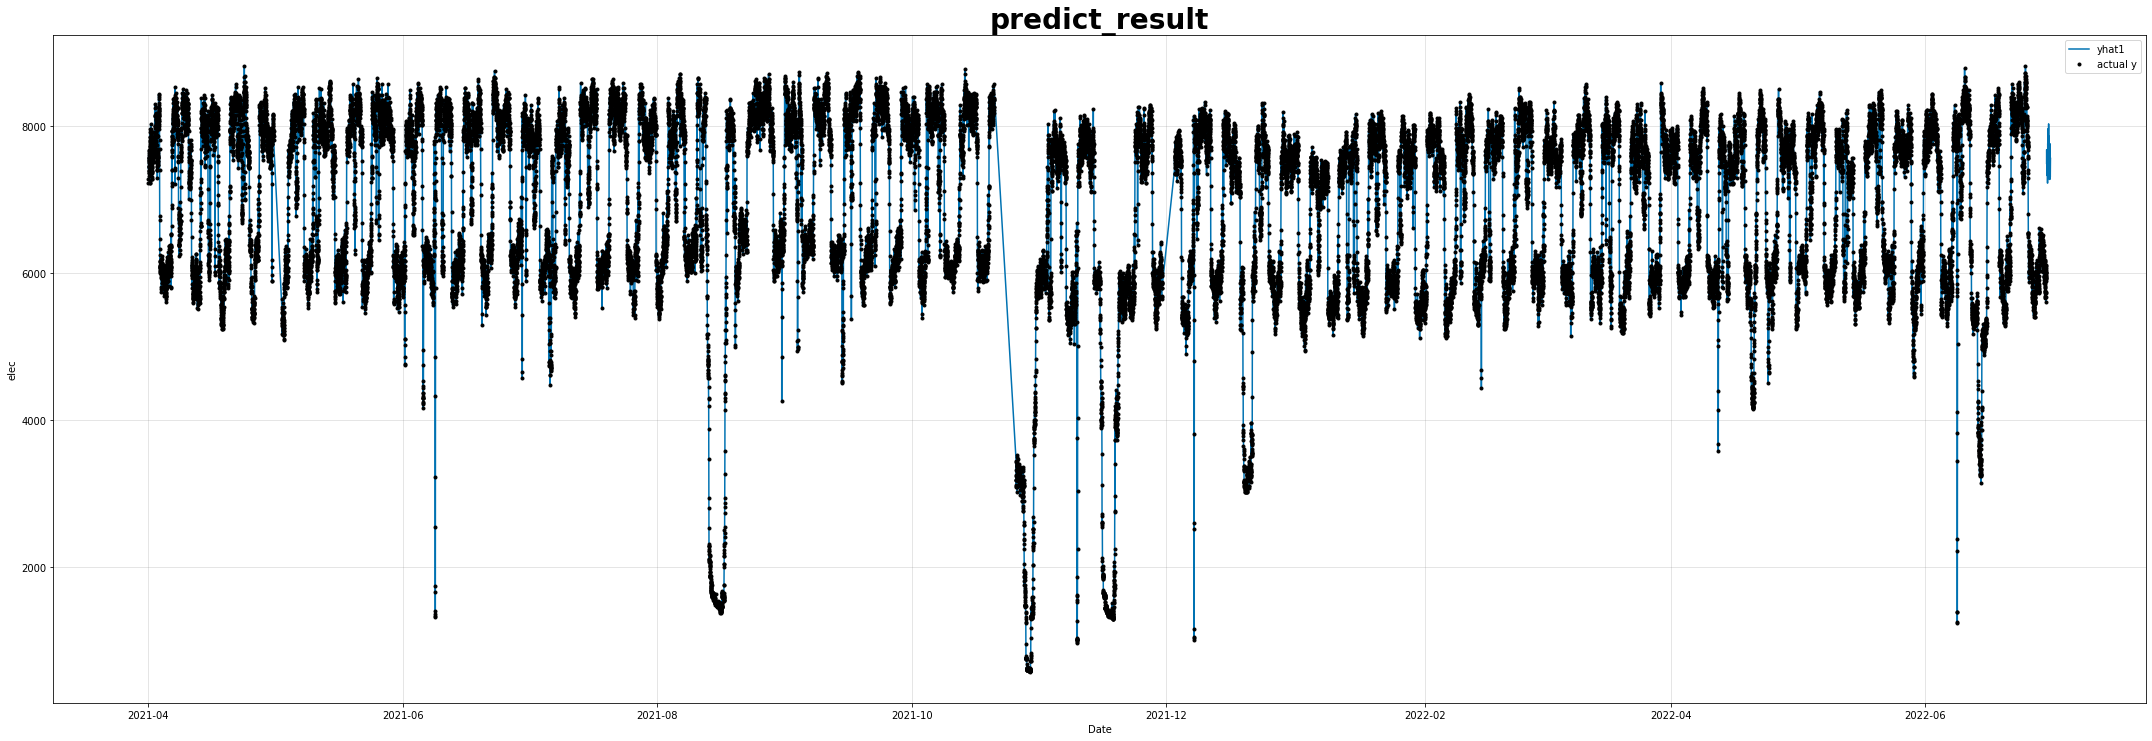

In [9]:
#train 후 예측
forecast=NP.NP_model_predict(df_train,model,num_futureregressor=10,predict_period=96)

In [11]:
# predict, real 비교 dataframe
result_df=NP.result_df(df_test,forecast)
result_df


,ds,y_x,y_y,yhat1,residual1,trend,season_weekly,season_daily,future_regressors_additive,future_regressor_d_1,future_regressor_d_2,future_regressor_d_3,future_regressor_d_4,future_regressor_d_5,future_regressor_l_1,future_regressor_l_2,future_regressor_l_3,future_regressor_l_4,future_regressor_l_5
0,2022-06-30 00:00:00,5846.4,NaN,NaN,NaN,-5181.655762,-0.017437,-0.041725,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2022-06-30 00:15:00,5812.8,NaN,NaN,NaN,-5181.655762,-0.017898,-0.052366,NaN,1512.128906,NaN,NaN,NaN,NaN,1971.476929,NaN,NaN,NaN,NaN
2,2022-06-30 00:30:00,5745.6,NaN,NaN,NaN,-5181.655762,-0.018332,-0.059797,NaN,1546.495483,1233.979858,NaN,NaN,NaN,1986.412598,1512.993408,NaN,NaN,NaN
3,2022-06-30 00:45:00,5712.0,NaN,NaN,NaN,-5181.655762,-0.018737,-0.063062,NaN,1482.671875,1210.770264,863.809082,NaN,NaN,2036.197144,1524.455444,914.792664,NaN,NaN
4,2022-06-30 01:00:00,5745.6,NaN,NaN,NaN,-5181.655762,-0.019113,-0.061675,NaN,1551.405029,1214.638550,882.042542,1299.171631,NaN,2021.261963,1562.662354,921.722961,1254.891235,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,2022-06-30 22:45:00,5628.0,NaN,7425.016113,NaN,-5181.655762,0.039888,0.012775,12606.619141,1531.766968,1168.219238,838.738098,1216.381226,955.927307,1996.369385,1574.124512,944.823669,1308.762817,1071.506104
92,2022-06-30 23:00:00,5560.8,NaN,7526.644043,NaN,-5181.655762,0.040937,0.005871,12708.252930,1526.857422,1233.979858,845.575684,1248.223633,1001.208130,2031.218750,1532.096924,951.753967,1296.087158,1041.251831
93,2022-06-30 23:15:00,5493.6,NaN,7492.794922,NaN,-5181.655762,0.041973,-0.004050,12674.413086,1487.581421,1199.165405,866.088257,1232.302368,1006.239258,2061.089600,1558.841675,926.343140,1305.593994,1031.166992
94,2022-06-30 23:30:00,5527.2,NaN,7543.032715,NaN,-5181.655762,0.042994,-0.016132,12724.662109,1512.128906,1187.560547,856.971497,1276.881836,1006.239258,2051.132812,1581.765869,942.513672,1270.735840,1038.730591


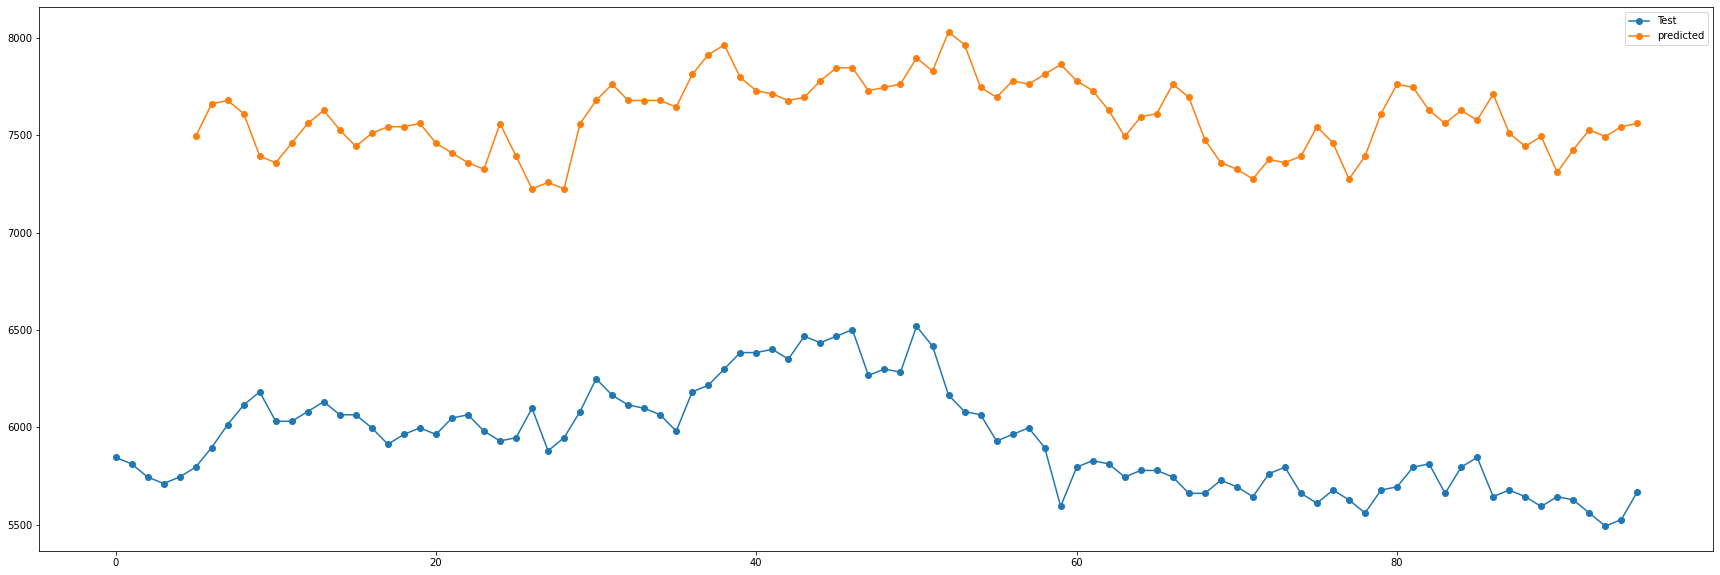

In [17]:
# predict, real 비교 plot
NP.predict_graph(result_df['y_x'],result_df['yhat1'])

In [18]:
# model save to disk
import pickle

filename = '/home/ykkim/Trained_Model/NeuralProphet_moorim_try1.sav'
pickle.dump(model, open(filename, 'wb'))